In [3]:
globals().clear()

import geopandas as gpd
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import math
from matplotlib.colors import LinearSegmentedColormap



os.chdir('C:/Users/lbeatty/Documents/Lauren_MIP_Contribution/')

#scenario = '26z-thin-debug'
scenario = '26z-short-base-50'
#scenario = '26z-short-current-policies'
model='GenX'
isrm=False  #plot output from isrm or full InMap?


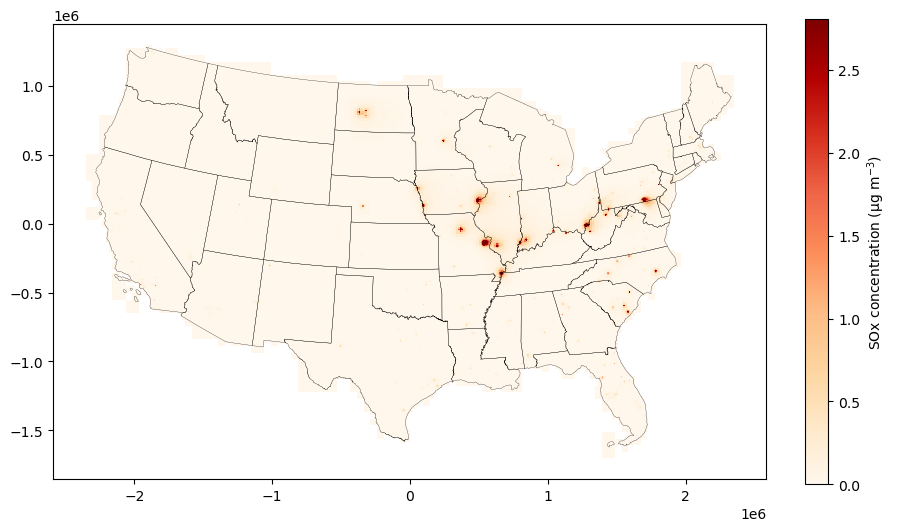

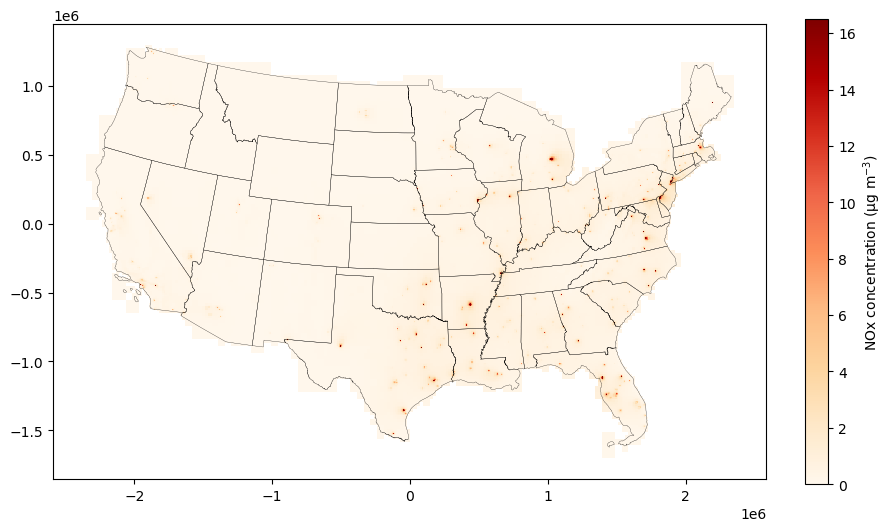

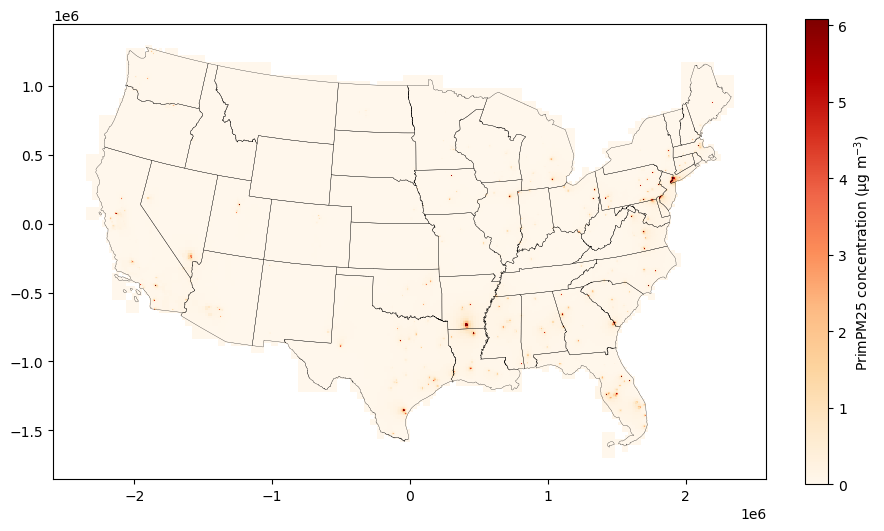

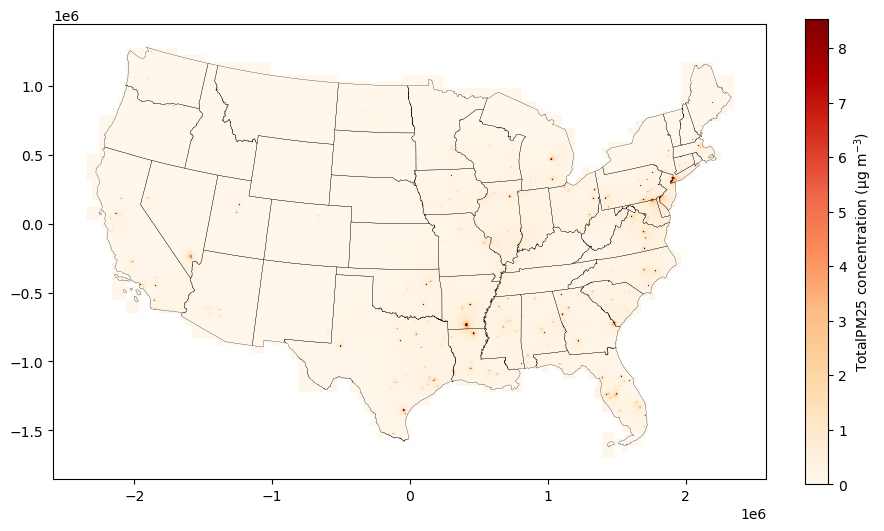

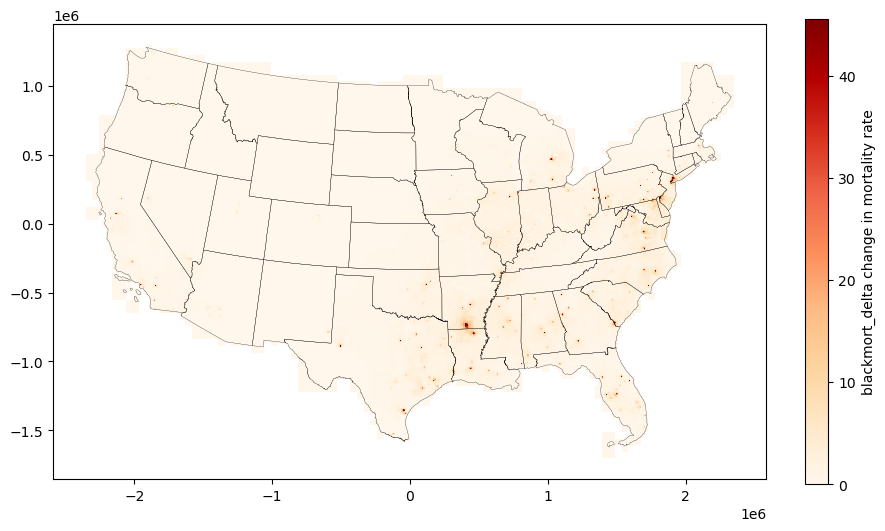

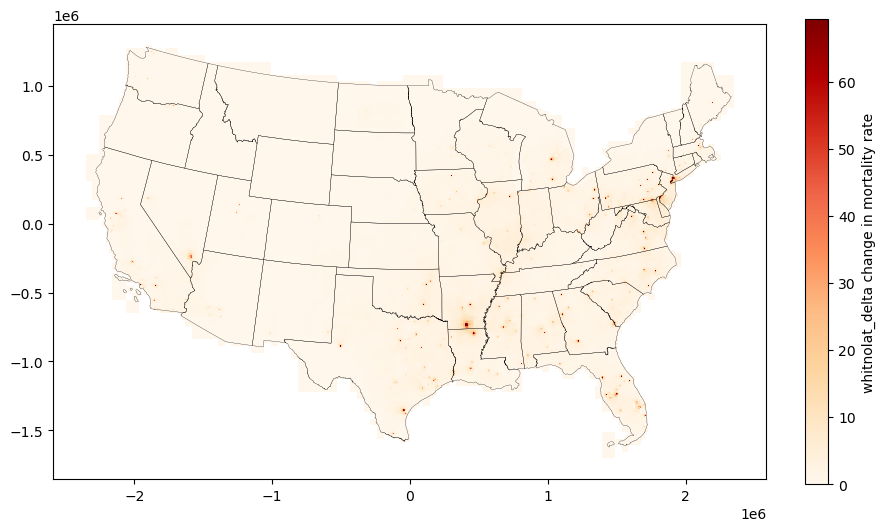

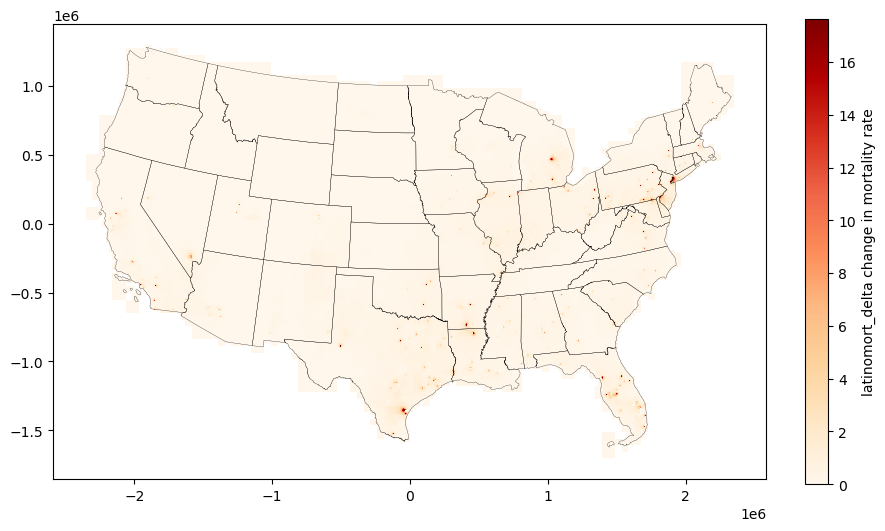

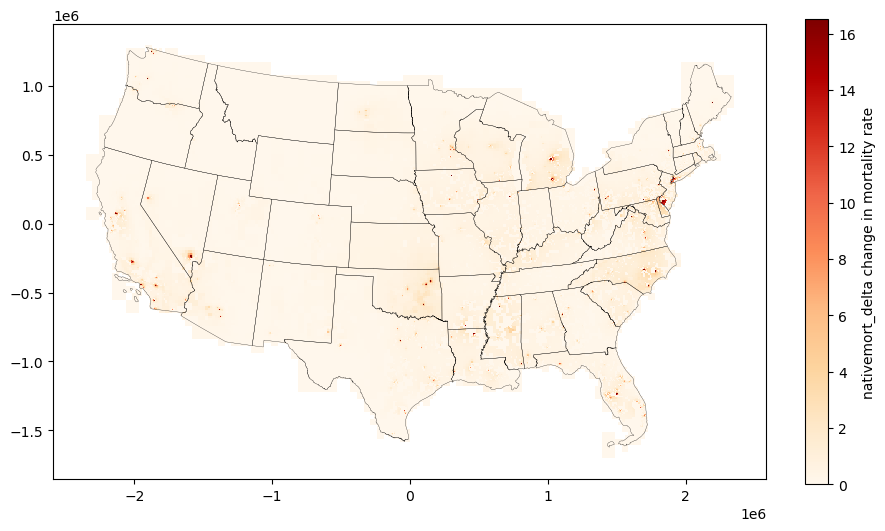

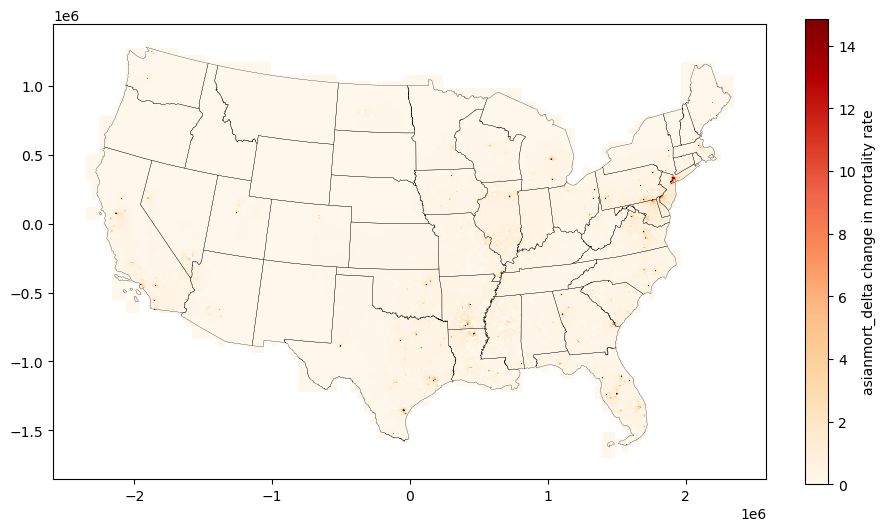

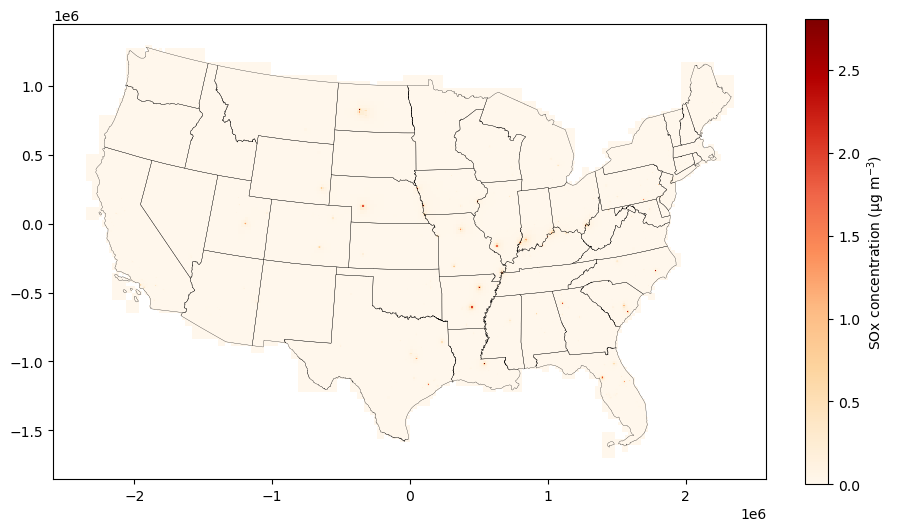

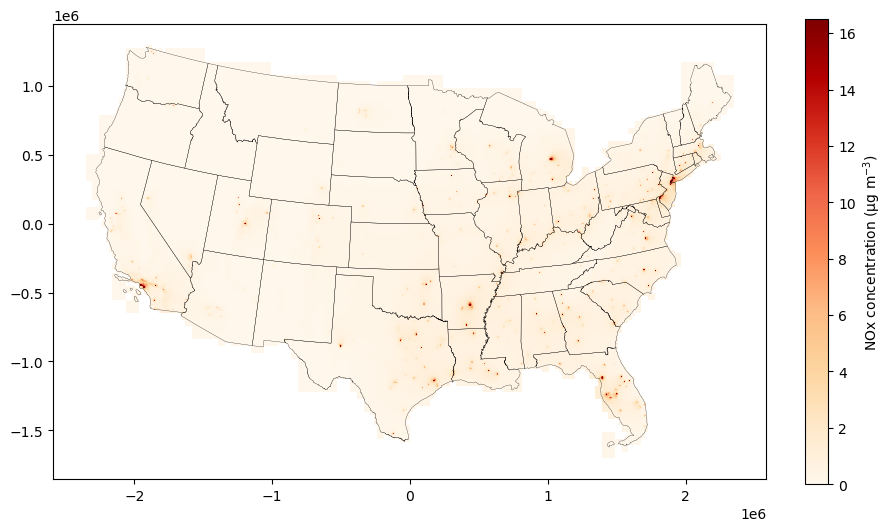

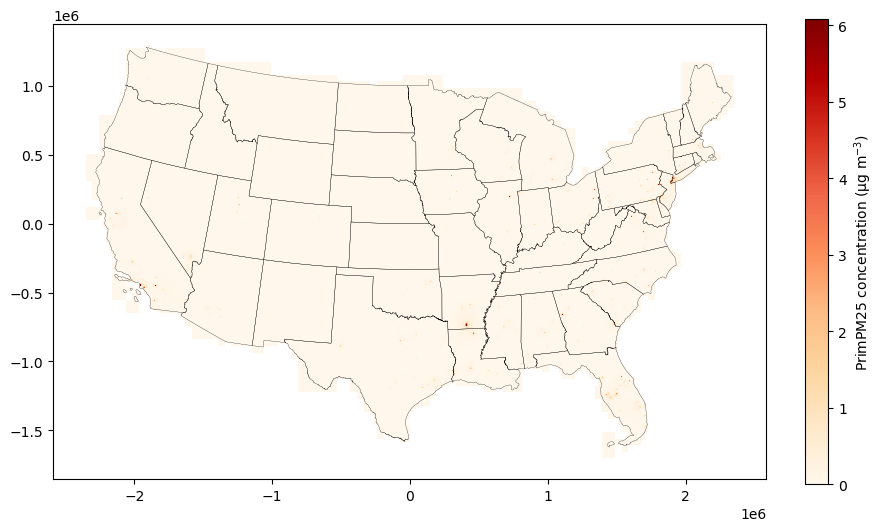

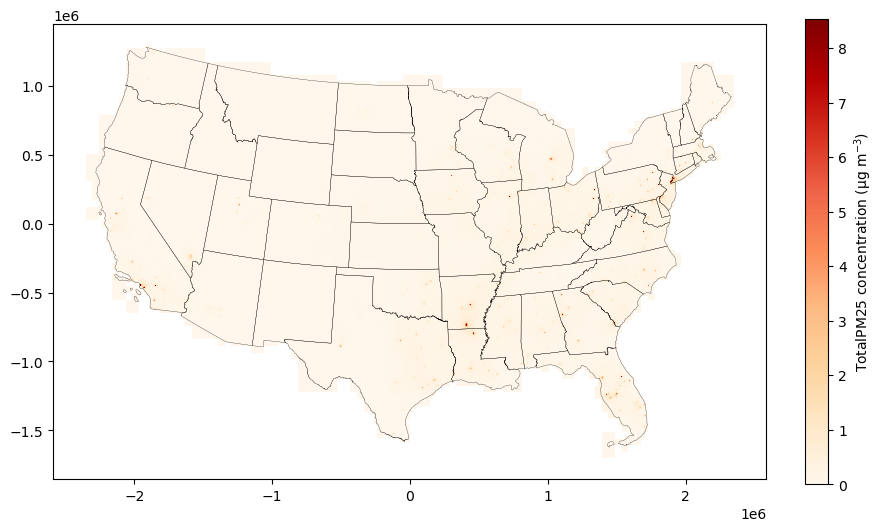

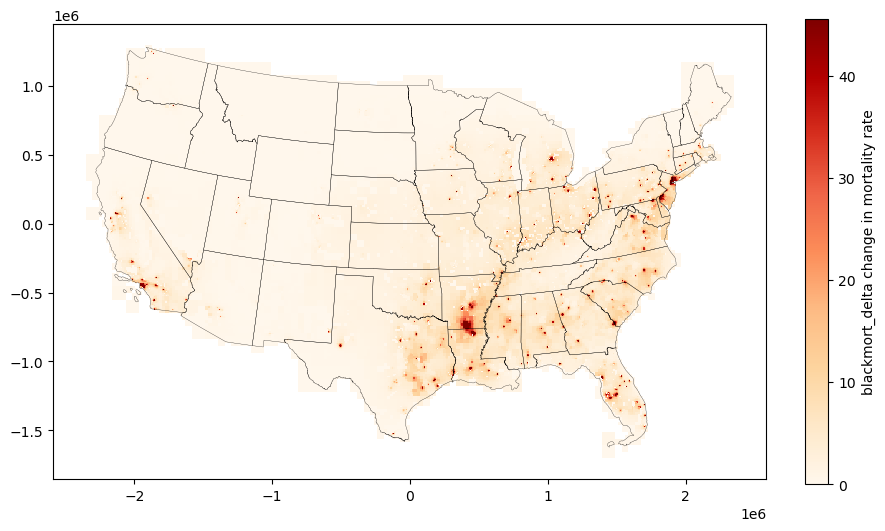

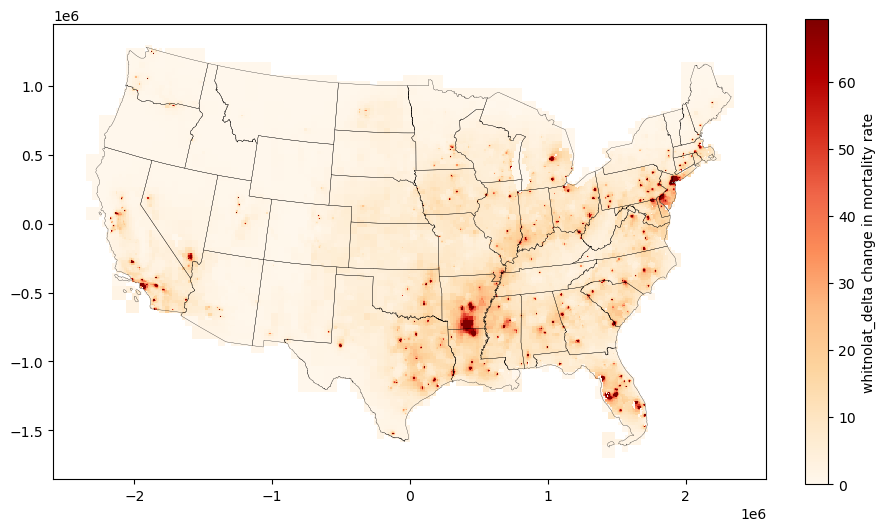

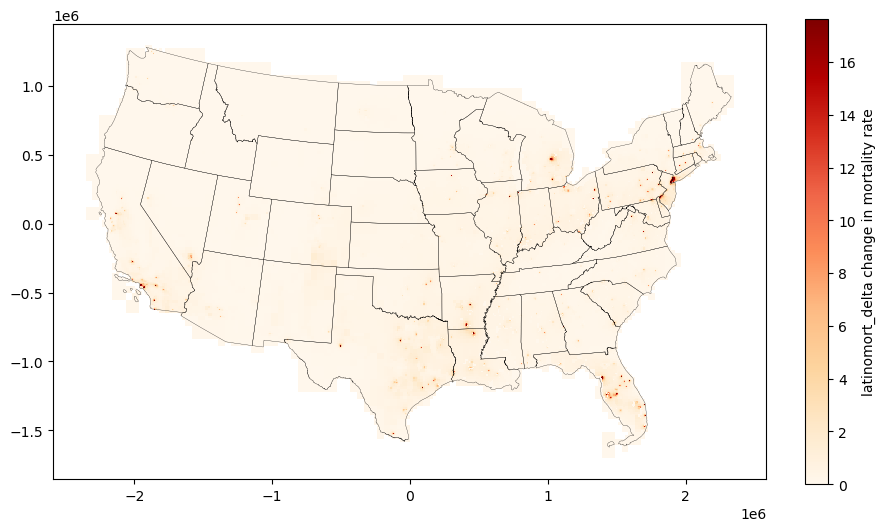

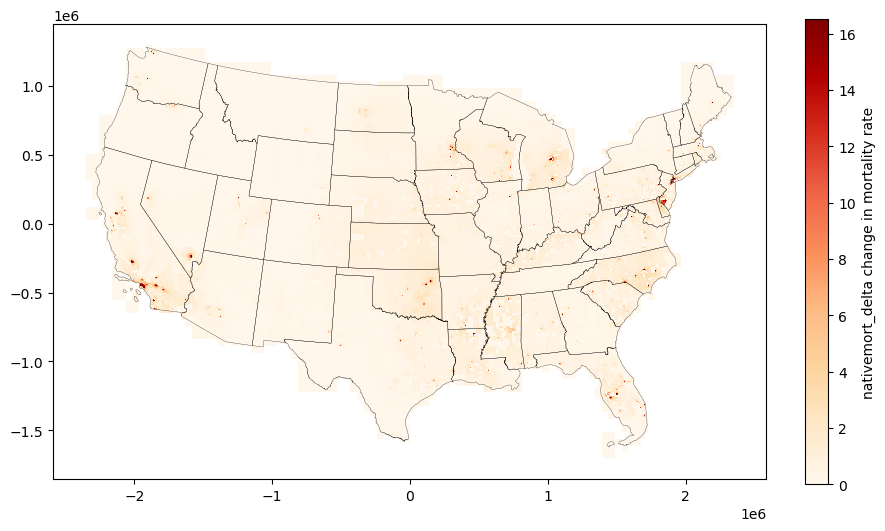

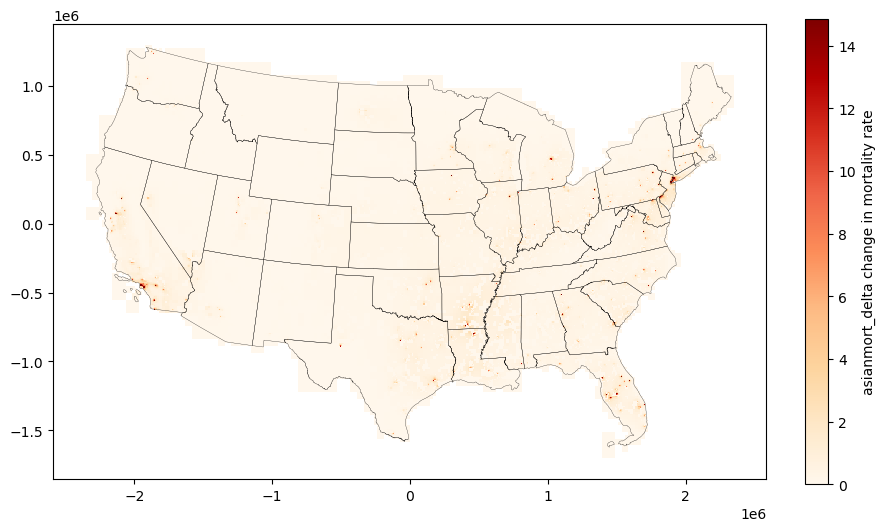

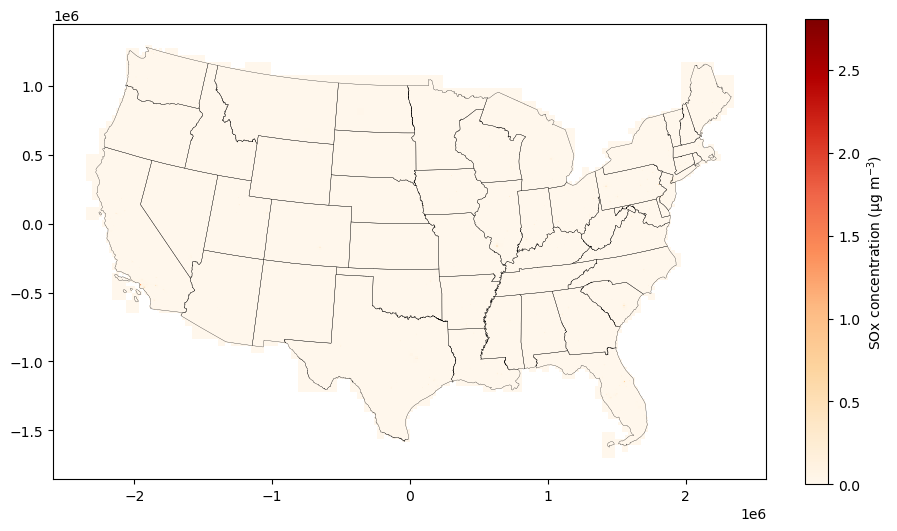

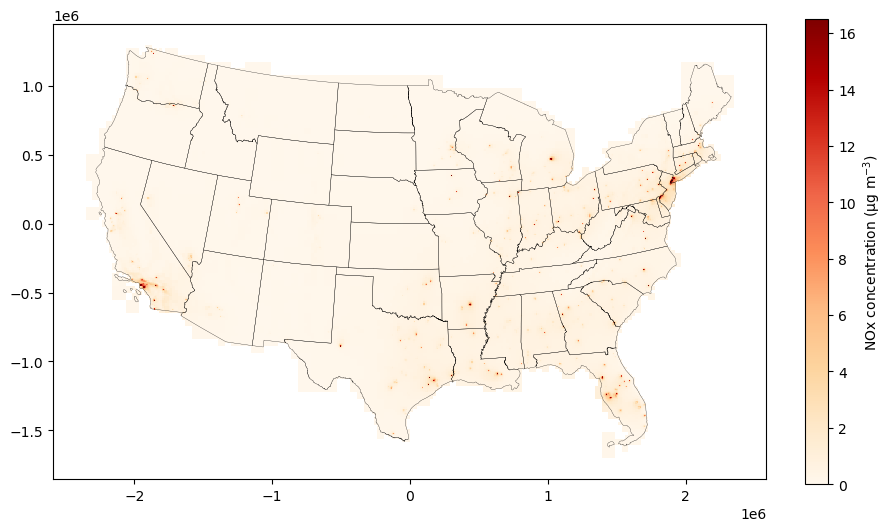

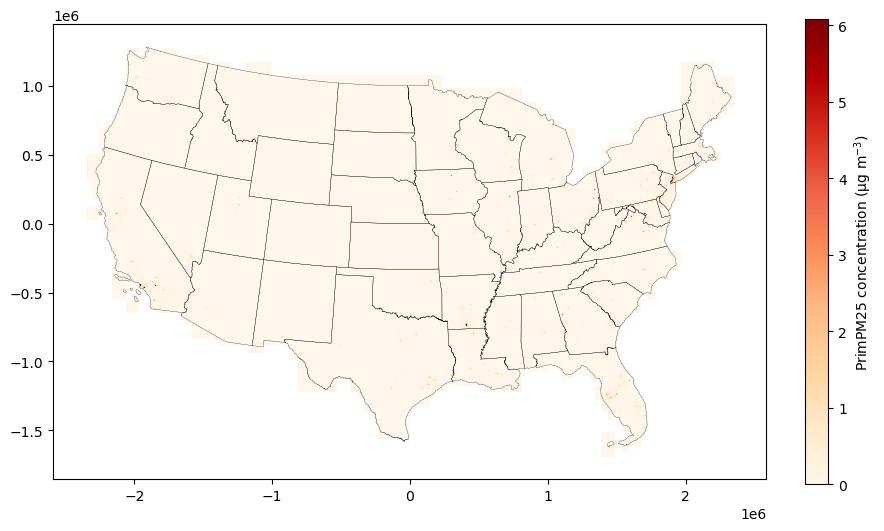

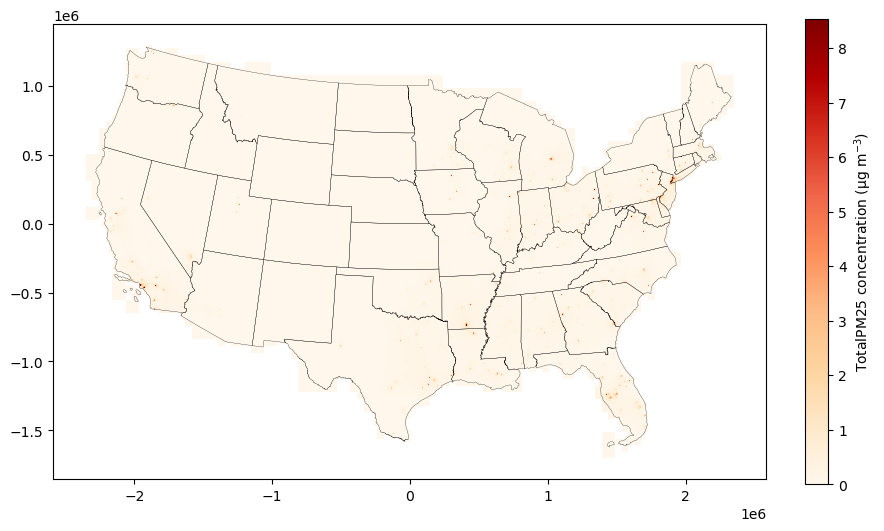

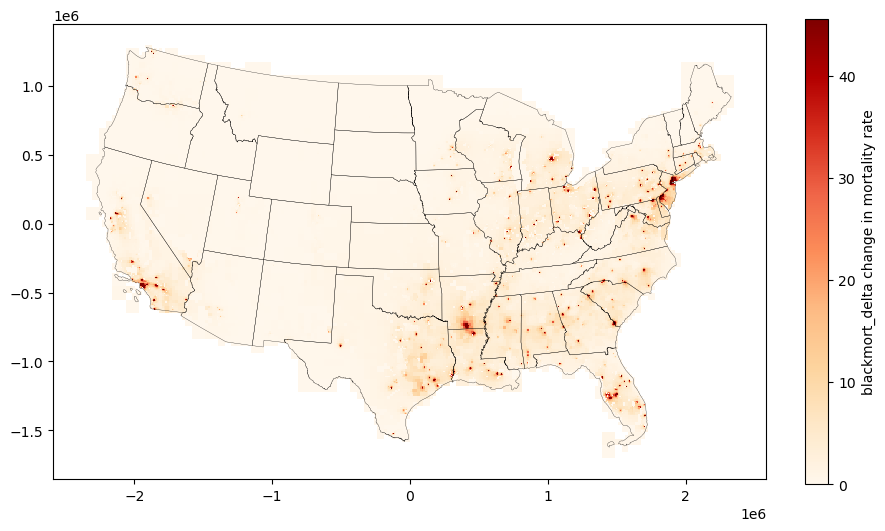

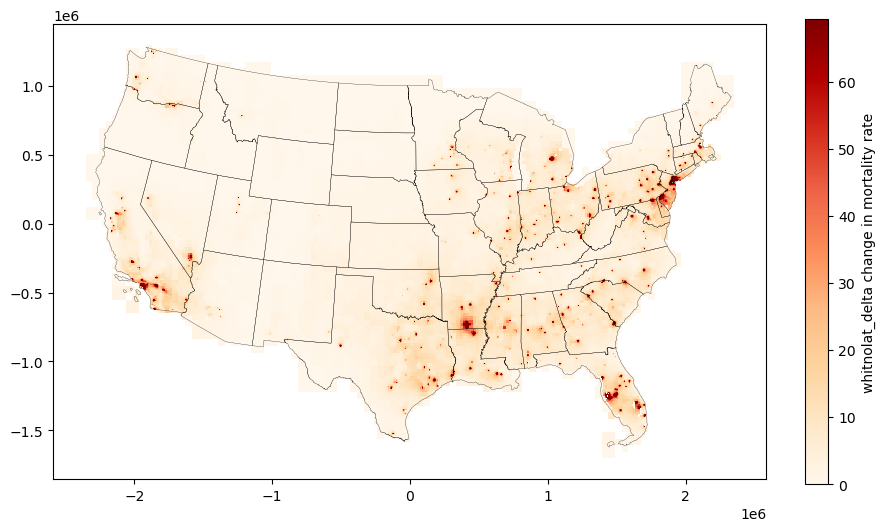

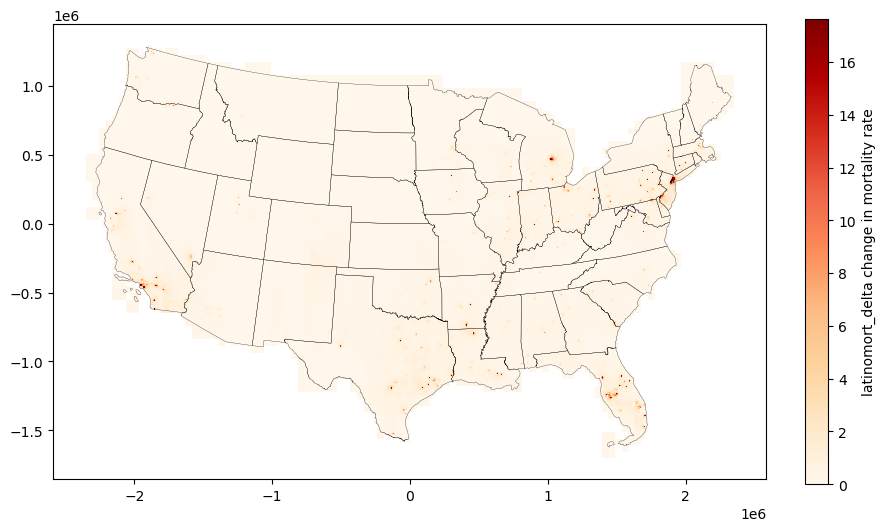

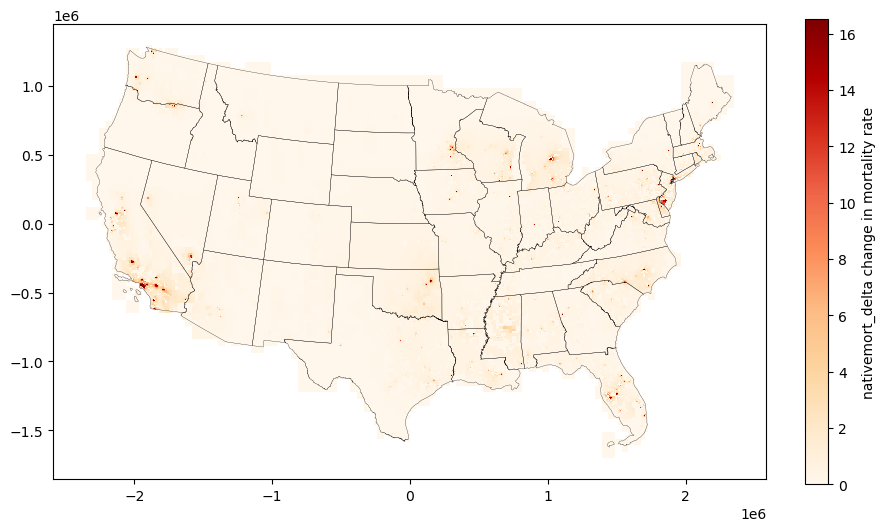

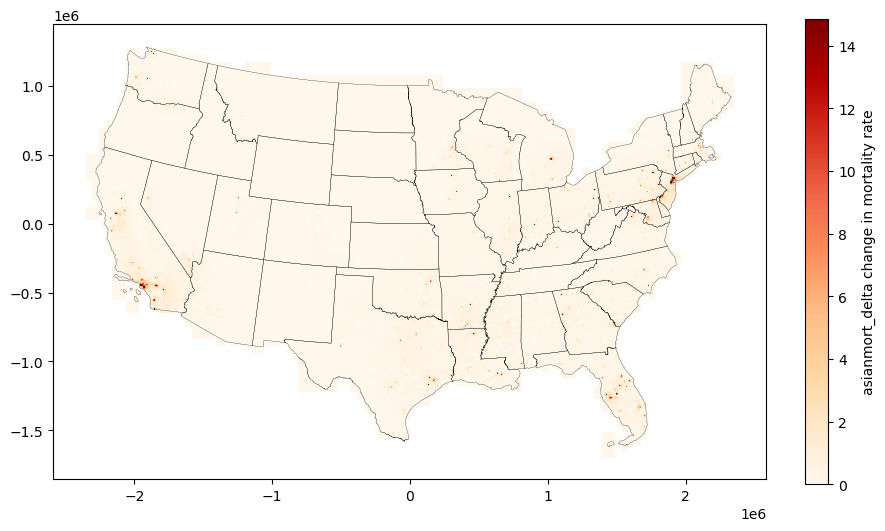

In [4]:
# Read the shapefiles
states = gpd.read_file('tl_2022_us_state/tl_2022_us_state.shp')
states = states[~states['STUSPS'].isin(['AS', 'AK', 'GU', 'MP', 'VI', 'HI', 'PR'])]

#Make folder for output if it doesn't exist
if not os.path.exists('MIP_AirPollution/Figures/Output/' + scenario + '/' + model):
    os.makedirs('MIP_AirPollution/Figures/Output/' + scenario + '/' + model)


#Plot output -- map of concentrations
years = ['2030', '2040', '2050']
quant_dict={}
for year in years:
    if isrm==False:
        emissions = gpd.read_file('InMap/MIP_InMap_Output/'+scenario+'/'+model+'/emissions'+year+'_out.shp')
    if isrm==True:
        emissions = gpd.read_file('InMap/MIP_InMap_Output/'+scenario+'/'+model+'/ISRM_result_'+year+'.shp')


    # Transform coordinates to match output
    #drop grid cells not in continental us
    states = states.to_crs(emissions.crs)
    intersects = emissions.geometry.intersects(states.unary_union)
    emissions['intersects'] = intersects
    emissions = emissions[emissions['intersects']==True]

    columns_to_plot = ['SOx', 'NOx', 'PrimPM25', 'TotalPM25']
    for column in columns_to_plot:

        #want scales to be the same for each plot
        if year=='2030':
            q = 0.99  # Truncate results at the 99th percentile for better visualization
            cut = np.quantile(emissions[column], q)
            quant_dict[column]=cut

        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot data with color scale truncated at the specified quantile
        emissions.plot(vmin=0, vmax=cut, cmap="OrRd", column=column, ax=ax)

        # Plot states boundaries
        states.boundary.plot(ax=ax, color='black', linewidth=0.2)

        # Add color bar
        sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=0, vmax=quant_dict[column]))
        sm._A = []  # Fake empty array for the colorbar
        cbar = fig.colorbar(sm, fraction=0.03)  
        cbar.set_label(column+' concentration (μg m$^{-3}$)')  # Set color bar label

        plt.savefig('MIP_AirPollution/Figures/Output/' + scenario + '/' + model + '/' +year+'_'+ column + '_concentrationmap.jpg', format='jpg',
                    dpi=300, bbox_inches='tight')
        plt.show()
    
    ## Now do delta Mortality rate
    emissions['blackmort_delta'] = ((math.log(1.078)/10 * emissions['TotalPM25']).apply(math.exp)-1)*emissions['blackmort'] - emissions['blackmort']/100000
    emissions['whitnolat_delta'] = ((math.log(1.078)/10 * emissions['TotalPM25']).apply(math.exp)-1)*emissions['whnolmort'] - emissions['whnolmort']/100000
    emissions['latinomort_delta'] = ((math.log(1.078)/10 * emissions['TotalPM25']).apply(math.exp)-1)*emissions['latinomort'] - emissions['latinomort']/100000
    emissions['asianmort_delta'] = ((math.log(1.078)/10 * emissions['TotalPM25']).apply(math.exp)-1)*emissions['asianmort'] - emissions['asianmort']/100000
    emissions['nativemort_delta'] = ((math.log(1.078)/10 * emissions['TotalPM25']).apply(math.exp)-1)*emissions['nativemort'] - emissions['nativemort']/100000

    columns_to_plot = ['blackmort_delta', 'whitnolat_delta', 'latinomort_delta', 'nativemort_delta', 'asianmort_delta']
    for column in columns_to_plot:

        #want scales to be the same for each plot
        if year=='2030':
            q = 0.99  # Truncate results at the 99th percentile for better visualization
            cut = np.quantile(emissions[column], q)
            quant_dict[column]=cut

        fig, ax = plt.subplots(figsize=(10, 8))

        # Plot data with color scale truncated at the specified quantile
        emissions.plot(vmin=0, vmax=cut, cmap="OrRd", column=column, ax=ax)

        # Plot states boundaries
        states.boundary.plot(ax=ax, color='black', linewidth=0.2)

        # Add color bar
        sm = plt.cm.ScalarMappable(cmap="OrRd", norm=plt.Normalize(vmin=0, vmax=quant_dict[column]))
        sm._A = []  # Fake empty array for the colorbar
        cbar = fig.colorbar(sm, fraction=0.03)  
        cbar.set_label(column+' change in mortality rate')  # Set color bar label

        plt.savefig('MIP_AirPollution/Figures/Output/' + scenario + '/' + model + '/' +year+'_'+ column + '_mortalityrate.jpg', format='jpg',
                    dpi=300, bbox_inches='tight')
        plt.show()


In [5]:
test = pd.DataFrame(emissions[['blackmort_delta', 'whitnolat_delta', 'latinomort_delta', 'blackmort', 'whnolmort', 'TotalPM25']])




In [6]:
#Plot deaths
import pandas as pd
print(emissions.columns)


years = ['2030', '2040', '2050']
emissions = pd.DataFrame()
for year in years:
    temp = gpd.read_file('InMap/MIP_InMap_Output/'+scenario+'/'+model+'/emissions'+year+'_out.shp')
    temp['year']=year
    emissions = pd.concat([emissions, temp])


Index(['AsianD', 'BaseMortR', 'BasePM25', 'BlackD', 'LatinoD', 'MortR', 'NH3',
       'NOx', 'NativeD', 'PNH4', 'PNO3', 'PSO4', 'PrimPM25', 'SOA', 'SOx',
       'TotalPM25', 'TotalPop', 'TotalPopD', 'WhitNoLatD', 'WindSpeed',
       'asianmort', 'blackmort', 'latinomort', 'nativemort', 'whnolmort',
       'geometry', 'intersects', 'blackmort_delta', 'whitnolat_delta',
       'latinomort_delta', 'asianmort_delta', 'nativemort_delta'],
      dtype='object')


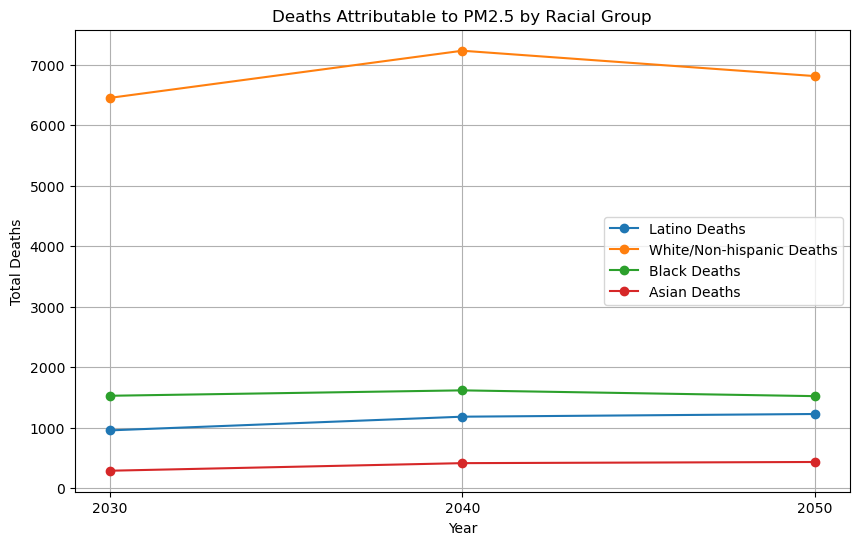

In [7]:
deaths = pd.DataFrame(emissions[['TotalPopD', 'NativeD', 'BlackD','AsianD', 'LatinoD', 'WhitNoLatD', 'year']])
deaths = deaths.groupby(['year']).sum().reset_index()

plt.figure(figsize=(10, 6))

# Plot mortality rates
plt.plot(deaths['year'], deaths['LatinoD'], marker='o', label='Latino Deaths')
plt.plot(deaths['year'], deaths['WhitNoLatD'], marker='o', label='White/Non-hispanic Deaths')
plt.plot(deaths['year'], deaths['BlackD'], marker='o', label='Black Deaths')
plt.plot(deaths['year'], deaths['AsianD'], marker='o', label='Asian Deaths')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Deaths Attributable to PM2.5 by Racial Group')
plt.legend()

# Show plot
plt.grid(True)
plt.savefig('MIP_AirPollution/Figures/Output/' + scenario + '/' + model + '/deaths_racial.jpg', format='jpg',dpi=300, bbox_inches='tight')
plt.show()

In [8]:
## group population-weighted exposure
